In [1]:
import sys
import logging
import numpy as np
import ds_mnist
import dnn
import log_setup
import matplotlib.pyplot as plt

log_setup.setup()

加载MNIST数据，并以ASCII方式，显示最前面两张图片对应的数字

In [2]:
# 全部数据为 70000 张
# True 则加载 1/10 的数据，加快加载和训练的速度，但效果会受影响
one_tenth=False

reader = ds_mnist.MnistRawReader(1, one_tenth=one_tenth)
reader.dump_image_idx(0)
reader.dump_image_idx(1)

[2023-04-25 16:24:42,052] [INFO]	[ds_mnist.py:23:_read_raw_file] loading mnist data file: ./datasets/mnist/train-images-idx3-ubyte
[2023-04-25 16:24:42,130] [INFO]	[ds_mnist.py:23:_read_raw_file] loading mnist data file: ./datasets/mnist/t10k-images-idx3-ubyte
[2023-04-25 16:24:42,146] [INFO]	[ds_mnist.py:23:_read_raw_file] loading mnist data file: ./datasets/mnist/train-labels-idx1-ubyte
[2023-04-25 16:24:42,178] [INFO]	[ds_mnist.py:23:_read_raw_file] loading mnist data file: ./datasets/mnist/t10k-labels-idx1-ubyte
[2023-04-25 16:24:49,206] [INFO]	[ds_mnist.py:71:distribution] training dataset:   [4881 5621 4993 5092 4852 4583 4903 5212 4897 4966], total 50000
[2023-04-25 16:24:49,221] [INFO]	[ds_mnist.py:71:distribution] validation dataset: [1042 1121  965 1039  990  838 1015 1053  954  983], total 10000
[2023-04-25 16:24:49,221] [INFO]	[ds_mnist.py:71:distribution] testing dataset:    [ 980 1135 1032 1010  982  892  958 1028  974 1009], total 10000


----------
label: 5
............................
............................
............................
............................
....................xxxx....
.................xxxxxxx....
..............xxxxxxxxx.....
.............xxxxxx.........
............xxxx............
...........xxxx.............
...........xxx..............
..........xxxx..............
.........xxxxx..............
.........xxxxxxxx...........
.........xxxxxxxxxx.........
.........xxx....xxx.........
.................xx.........
................xxx.........
...............xxxx.........
......xx.......xxxx.........
.....xxx......xxxx..........
.....xxxxxx.xxxxx...........
......xxxxxxxxxx............
........xxxxxx..............
............................
............................
............................
............................

----------
label: 0
............................
............................
............................
............................
............................
..

切分训练集、验证集、测试集数据，比例为5:1:1。

In [3]:
#train_data, validation_data, test_data = ds_mnist.load_data_set(ds_mnist.NO_SHUFFLE, one_tenth=one_tenth)
train_data, validation_data, test_data = ds_mnist.load_data_set(ds_mnist.SHUFFLE_ALL, one_tenth=one_tenth)
n_train, n_eval, n_test = len(train_data[0]), len(validation_data[0]), len(test_data[0])
print(len(train_data[0]), len(validation_data[0]), len(test_data[0]))
print(len(train_data[1]), len(validation_data[1]), len(test_data[1]))

[2023-04-25 16:24:49,284] [INFO]	[ds_mnist.py:23:_read_raw_file] loading mnist data file: ./datasets/mnist/train-images-idx3-ubyte
[2023-04-25 16:24:49,364] [INFO]	[ds_mnist.py:23:_read_raw_file] loading mnist data file: ./datasets/mnist/t10k-images-idx3-ubyte
[2023-04-25 16:24:49,380] [INFO]	[ds_mnist.py:23:_read_raw_file] loading mnist data file: ./datasets/mnist/train-labels-idx1-ubyte
[2023-04-25 16:24:49,395] [INFO]	[ds_mnist.py:23:_read_raw_file] loading mnist data file: ./datasets/mnist/t10k-labels-idx1-ubyte
[2023-04-25 16:24:56,896] [INFO]	[ds_mnist.py:71:distribution] training dataset:   [4907 5600 5035 5145 4831 4500 4940 5249 4882 4911], total 50000
[2023-04-25 16:24:56,896] [INFO]	[ds_mnist.py:71:distribution] validation dataset: [ 981 1131  967  983 1018  888  954 1070  996 1012], total 10000
[2023-04-25 16:24:56,911] [INFO]	[ds_mnist.py:71:distribution] testing dataset:    [1015 1146  988 1013  975  925  982  974  947 1035], total 10000


50000 10000 10000
50000 10000 10000


In [4]:
model_file = 'model_mnist.json'

def train_nn_v2():
    net = dnn.NeuralNetwork(input_size=784, fc_sizes=[30, 10], lr=0.03, loss='ce',
            #l2reg=5,
            #momentum=0.7,
            l2reg=1e-3,
            #l1reg=3,
            #dropout=0.2,
            activations=['relu', 'sigmoid'],
            stride=8)
    train_stat, eval_stat = net.train(train_data, epochs=10, batch_size=64,
            eval_data=validation_data, collect_eval_stat=True, collect_train_stat=True)
    net.save(model_file)
    return net, train_stat, eval_stat

def load_n_eval(max_show = 3):
    net = dnn.NeuralNetwork.load(model_file)
    result = net.evaluate(test_data[0], test_data[1], label_is_matrix=False)
    n_correct = np.sum(result[:,0] == result[:,1])
    acc = 1.0 * n_correct / len(test_data[0])
    logging.info('test data set: accuracy %5d / %5d = %.4f' % (
        n_correct, len(test_data[0]), acc))
    if max_show <= 0:
        return net, acc

    n = 0
    for img, l, p in list(zip(test_data[0], test_data[1], result)):
        if p[0] != l and n < max_show:
            print('# %d - predict: %d, actual: %d' % (n + 1, p[0], l))
            ds_mnist.dump_one(img)
            n += 1

    return net, acc


训练并保存模型

In [5]:
net, train_stat, eval_stat = train_nn_v2()

[2023-04-25 16:24:56,986] [INFO]	[dnn.py:123:__init__] init fc-layer #1: w shape (784, 30) mean -0.000023, b shape (30,) mean -0.215305, act relu
[2023-04-25 16:24:56,986] [INFO]	[dnn.py:123:__init__] init fc-layer #2: w shape (30, 10) mean 0.004632, b shape (10,) mean -0.212873, act sigmoid
[2023-04-25 16:24:57,027] [INFO]	[dnn.py:187:train] training args: lr=0.03, l2reg=0.001, l1reg=0, dropout=0, momentum=0, stride=8, epochs=10, batch_size=64, n_samples=50000
[2023-04-25 16:25:06,652] [INFO]	[dnn.py:202:train] 9.405 sec, finish epoch 1 / 10
[2023-04-25 16:25:07,683] [INFO]	[dnn.py:210:train] dataset train: loss 0.8783 0.9185, accuracy 44146 / 50000 = 0.8829
[2023-04-25 16:25:07,915] [INFO]	[dnn.py:217:train] dataset eval:  loss 0.8838 0.9240, accuracy  8827 / 10000 = 0.8827
[2023-04-25 16:25:17,482] [INFO]	[dnn.py:202:train] 9.362 sec, finish epoch 2 / 10
[2023-04-25 16:25:18,546] [INFO]	[dnn.py:210:train] dataset train: loss 0.7090 0.7579, accuracy 45012 / 50000 = 0.9002
[2023-04-25

[[4.41460000e+04 8.78344363e-01 9.18503953e-01]
 [4.50120000e+04 7.09030369e-01 7.57905228e-01]
 [4.54660000e+04 6.37494159e-01 6.91914304e-01]
 [4.58300000e+04 5.93473389e-01 6.52187706e-01]
 [4.60320000e+04 5.63042244e-01 6.25373822e-01]
 [4.62100000e+04 5.37352239e-01 6.02738288e-01]
 [4.63800000e+04 5.20060142e-01 5.88215314e-01]
 [4.64620000e+04 5.01335812e-01 5.71979829e-01]
 [4.65170000e+04 4.92670740e-01 5.65489644e-01]
 [4.65140000e+04 4.93702027e-01 5.68564584e-01]] [[8.82700000e+03 8.83844709e-01 9.24004298e-01]
 [8.94700000e+03 7.22767540e-01 7.71642399e-01]
 [9.06700000e+03 6.56545769e-01 7.10965914e-01]
 [9.12300000e+03 6.15384668e-01 6.74098984e-01]
 [9.16500000e+03 5.87268037e-01 6.49599616e-01]
 [9.22100000e+03 5.63772332e-01 6.29158381e-01]
 [9.23500000e+03 5.48565329e-01 6.16720500e-01]
 [9.26500000e+03 5.33492063e-01 6.04136079e-01]
 [9.27600000e+03 5.27166598e-01 5.99985502e-01]
 [9.25700000e+03 5.29827537e-01 6.04690094e-01]]


Text(0, 0.5, 'accuracy')

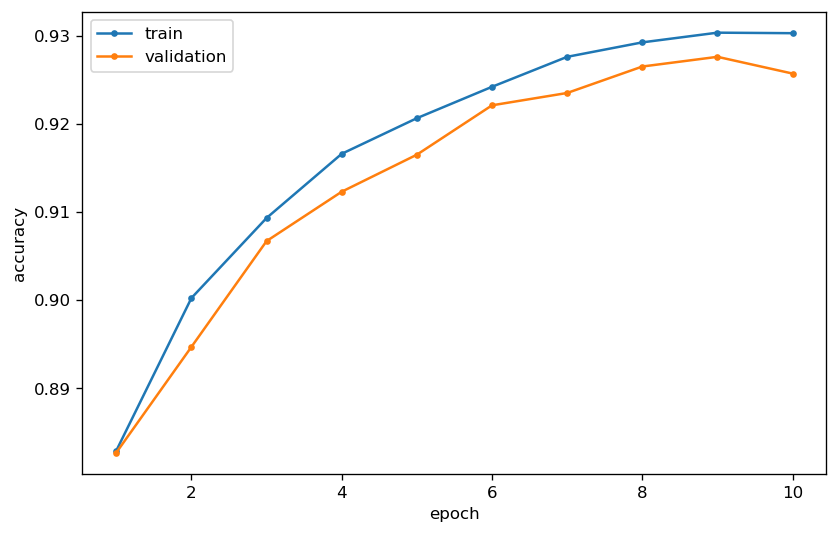

In [6]:
print(train_stat, eval_stat)

plt.figure(figsize=(8,5), dpi=120)
x = np.arange(train_stat.shape[0]) + 1
plt.plot(x, train_stat[:,0] / n_train, marker='.', label='train')
plt.plot(x, eval_stat[:,0] / n_eval,   marker='.', label='validation')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('accuracy')

加载模型、预测验证，打印部分分类错误的数字。

In [7]:
net, test_acc = load_n_eval(5)
print('test_acc: {:.4f}'.format(test_acc))

[2023-04-25 16:26:44,580] [INFO]	[dnn.py:276:load] loading model from file: model_mnist.json
[2023-04-25 16:26:44,611] [INFO]	[dnn.py:123:__init__] init fc-layer #1: w shape (784, 30) mean -0.000204, b shape (30,) mean 0.166382, act relu
[2023-04-25 16:26:44,611] [INFO]	[dnn.py:123:__init__] init fc-layer #2: w shape (30, 10) mean 0.003918, b shape (10,) mean -0.226064, act sigmoid
[2023-04-25 16:26:44,658] [INFO]	[3469783925.py:22:load_n_eval] test data set: accuracy  9187 / 10000 = 0.9187


# 1 - predict: 2, actual: 5
............................
............................
............................
............................
...........x..xx............
..........xxxxxxx...........
........xxxxxxxxx...........
........xxxxxxx.............
........xxxx................
.........xx.................
.........xx.................
........xxx.................
........xxx.................
........xxx.................
........xx..................
.......xxx...xxxxxx.........
.......xxxxxxxxxxxxxxxx.....
.......xxxxxxxxxxxxxxxx.....
........xxxxxxxxxxxx.xxx....
........xxxxx..........xx...
........xxx............xxx..
........................xx..
.......................xxx..
.......................xxx..
............................
............................
............................
............................
# 2 - predict: 1, actual: 9
............................
............................
............................
............................
................